In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
# pd.set_option('display.max_columns', 1000)
# pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('..')

In [2]:
DATA = Path('data')
RAW  = DATA/'raw'
SUBMISSIONS = DATA/'submissions'

In [3]:
train      = pd.read_csv(RAW/'train_jqd04QH.csv', low_memory=False)
test       = pd.read_csv(RAW/'test_GYi4Gz5.csv', low_memory=False)
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)

In [4]:
id_col = 'enrollee_id'
cat_cols = ['city', 'gender', 'relevent_experience', 'enrolled_university', 
            'education_level', 'major_discipline', 'experience', 'company_size', 
            'company_type', 'last_new_job']
num_cols = ['city_development_index', 'training_hours']
target_col = 'target'

In [5]:
def get_dict(labels):
    return {label: idx for idx, label in enumerate(labels)}

labels = {
    'enrolled_university': get_dict(['no_enrollment', 'Part time course',
                                     'Full time course']),
    'education_level': get_dict(['Primary School', 'High School', 
                                 'Graduate', 'Masters', 'Phd']),
    'experience': get_dict(['<1'] + \
                           [str(x) for x in range(1,21)] + ['>20']),
    'company_size': get_dict(['<10', '10/49', '50-99', '100-500', 
                              '500-999', 
                              '1000-4999', '5000-9999', '10000+']),
    'last_new_job': get_dict([str(x) for x in range(1,5)] + \
                             ['>4', 'never'])
}

In [9]:
for col in labels:
    data[f'{col}_num'] = data[col].map(labels[col])

In [6]:
reverse_labels = {col: {v: k for k, v in labels[col].items()} for col in labels}

In [8]:
data = pd.concat([train.drop(target_col, axis=1), test])

In [12]:
company_sizes = {e: reverse_labels['company_size'][int(data[data.education_level == e]\
                                   .company_size_num.median())] \
                 for e in data.education_level.unique() if e == e}

In [13]:
company_sizes

{'Graduate': '100-500',
 'High School': '50-99',
 'Masters': '100-500',
 'Phd': '500-999',
 'Primary School': '50-99'}

In [17]:
train['company_size'] = [company_sizes[e] if c != c and e == e else c for c, e in \
                            zip(train.company_size, train.education_level)]
test['company_size'] = [company_sizes[e] if c != c and e == e else c for c, e in \
                            zip(test.company_size, test.education_level)]

In [18]:
train.isnull().sum(0)

enrollee_id                  0
city                         0
city_development_index       0
gender                    4098
relevent_experience          0
enrolled_university        342
education_level            457
major_discipline          2838
experience                  59
company_size               292
company_type              5039
last_new_job               367
training_hours               0
target                       0
dtype: int64

In [20]:
%%time
from src.utils import preprocess
preprocess(train, test, cat_cols, num_cols)

CPU times: user 360 ms, sys: 28 ms, total: 388 ms
Wall time: 383 ms


## Models

In [22]:
from sklearn.model_selection import StratifiedKFold
columns = list(train.drop([id_col, target_col], axis=1))
cat_indices = [i for i, col in enumerate(columns) if col in cat_cols]
kfolds = StratifiedKFold(n_splits=5, random_state=42)

In [23]:
from src.utils import eval_catboost
from catboost import CatBoostClassifier

In [27]:
%%time
trn_aucs, val_aucs = eval_catboost(CatBoostClassifier(
                        random_seed=42, eval_metric='AUC', od_pval=1e-3),
                    train.drop([id_col, target_col], axis=1), 
                    train[target_col], kfolds, cat_indices)

No. estimators: 489 | Train AUC: 70.77 | Val AUC: 69.06
No. estimators: 826 | Train AUC: 73.13 | Val AUC: 63.67
No. estimators: 576 | Train AUC: 71.97 | Val AUC: 66.16
No. estimators: 826 | Train AUC: 72.38 | Val AUC: 67.13
No. estimators: 443 | Train AUC: 71.13 | Val AUC: 67.83

CPU times: user 12min 15s, sys: 1min, total: 13min 15s
Wall time: 1min 24s


In [26]:
from src.utils import print_results
# n_estimators 1000 | max_depth 7
print_results(trn_aucs, val_aucs)

Train AUC: 72.59 +/- 1.21 | Val AUC: 66.90 +/- 3.73


In [28]:
# default
print_results(trn_aucs, val_aucs)

Train AUC: 71.87 +/- 1.70 | Val AUC: 66.77 +/- 3.63


In [30]:
%%time
model = CatBoostClassifier(iterations=500, eval_metric='AUC')
model.fit(train.drop([id_col, target_col], axis=1), train[target_col],
          cat_features=cat_indices, verbose=False)
y_test = model.predict_proba(test.drop(id_col, axis=1))[:,1]

CPU times: user 1min 19s, sys: 6.36 s, total: 1min 25s
Wall time: 9.47 s


In [31]:
X_train = train.drop([id_col, target_col], axis=1)
y_train = train[target_col]

In [32]:
y_pred = model.predict_proba(X_train)[:,1]

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_pred)

0.7133898594589279

In [35]:
from catboost import Pool
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, 
                                      model.get_feature_importance(
                                          Pool(X_train, label=y_train, 
                                               cat_features=cat_indices)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, 
                                inplace=False, na_position='last')

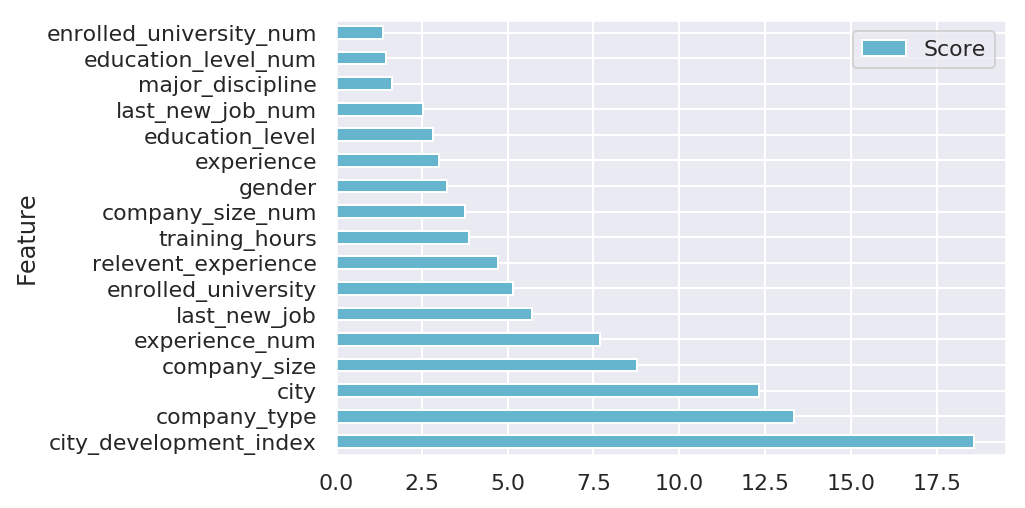

In [36]:
feature_score.plot('Feature', 'Score', kind='barh', color='c')

In [37]:
test[target_col] = y_test
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)
submission = pd.merge(submission[[id_col]], test[[id_col, target_col]], how='left', on=id_col)

In [38]:
submission[target_col].describe()

count    15021.000000
mean         0.130276
std          0.072373
min          0.049687
25%          0.079281
50%          0.101874
75%          0.154870
max          0.668623
Name: target, dtype: float64

In [39]:
submission.to_csv(SUBMISSIONS/'24-catboost_fillnan.csv', index=False)